In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
def input_reshape(x):
    return tf.reshape(x, [-1,28,28,1])

def get_weights(shape, name):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name = name)

def get_bias(shape, name):
    return tf.Variable(tf.constant(value = 0.1, shape = shape), name = name)

def conv2d(x, W, padding, strides):
    return tf.nn.conv2d(x, W, strides=strides, padding=padding)

def maxpool2x2(x):
    return tf.nn.max_pool(x, strides=[1,2,2,1], padding='VALID', ksize=[1,2,2,1])

def build_model(x_ip):
    
    with tf.name_scope('reshape'):
        x = tf.reshape(x_ip, [-1, 28, 28, 1])
    
    # First convolutional layer - maps one grayscale image to 32 feature maps.
    with tf.name_scope('conv1'):
        W_conv1 = get_weights([12, 12, 1, 25], 'w_conv1')
        b_conv1 = get_bias([25], 'b_conv1')
        h_conv1 = tf.nn.relu(conv2d(x, W_conv1, 'VALID', [1,2,2,1]) + b_conv1, name='h_conv1')
        tf.summary.histogram("weights", W_conv1)
        tf.summary.histogram("biases", b_conv1)
        tf.summary.histogram("activations", h_conv1)


    # Second convolutional layer -- maps 32 feature maps to 64.
    with tf.name_scope('conv2'):
        W_conv2 = get_weights([5, 5, 25, 64], 'w_conv2')
        b_conv2 = get_bias([64], 'b_conv2')
        h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 'SAME', [1,1,1,1]) + b_conv2, name='h_conv2')
        tf.summary.histogram("weights", W_conv2)
        tf.summary.histogram("biases", b_conv2)
        tf.summary.histogram("activations", h_conv2)
    
    # Second pooling layer.
    with tf.name_scope('pool2'):
        h_pool2 = maxpool2x2(h_conv2)
    
    #Fully connected layer 1
    with tf.name_scope('fc1'):
        shape = h_pool2.get_shape().as_list()
        W_fc1 = get_weights([shape[1] * shape[2] * shape[3], 1024], 'w_fc1')
        b_fc1 = get_bias([1024], 'b_fc1')
        tf.summary.histogram("weights", W_fc1)
        tf.summary.histogram("biases", b_fc1)
        h_pool2_flat = tf.reshape(h_pool2, [-1, shape[1] * shape[2] * shape[3]])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name='h_fc1')
        tf.summary.histogram("activations", h_fc1)

    #Fully connected layer 2
    with tf.name_scope('fc2'):
        W_fc2 = get_weights([1024, 10], 'w_fc2')
        b_fc2 = get_bias([10], 'b_fc2')
        tf.summary.histogram("weights", W_fc2)
        tf.summary.histogram("biases", b_fc2)
        y_conv = tf.add(tf.matmul(h_fc1, W_fc2), b_fc2, name='y_conv')
        tf.summary.histogram("activations", y_conv)
    return y_conv

In [3]:
def train(train_data, iters):
    x = tf.placeholder(tf.float32, shape=[None, 784], name = 'x')
    y = tf.placeholder(tf.float32, shape=[None, 10], name = 'y')
    
    y_pre_softmax = build_model(x)
    
    with tf.name_scope('cross_entropy'):    
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pre_softmax)
        cross_entropy = tf.reduce_mean(cross_entropy, name='cross_entropy')
    
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        tf.summary.scalar('cross_entropy', cross_entropy)
    
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_pre_softmax, 1), tf.argmax(y, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction, name = 'accuracy')
        tf.summary.scalar('accuracy', accuracy)
    
    summ = tf.summary.merge_all()
    
    builder = tf.saved_model.builder.SavedModelBuilder('models/')
    writer = tf.summary.FileWriter('logs_output_2')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer.add_graph(sess.graph)
        for i in range(iters):
            batch = train_data.next_batch(50)
            sess.run([train_step], feed_dict={x:batch[0], y:batch[1]})
            if i%10 == 0:
                acc, s = sess.run([accuracy, summ],feed_dict={x:batch[0], y:batch[1]})
                print("Accuracy after "+str(i)+" iterations is "+str(acc))
                writer.add_summary(s, i)
        builder.add_meta_graph_and_variables(sess,['model_'+str(iters)+'iters'])
        builder.save()
        writer.close()
        print("Complete!")
    return

In [4]:
def test(test_data, iters):
    tf.reset_default_graph()
    with tf.Session() as sess:
        tf.saved_model.loader.load(sess,['model_'+str(iters)+'iters'],'models/')
        acc = sess.run(['accuracy/accuracy:0'], feed_dict={'x:0':test_data.images, 'y:0':test_data.labels})
        print("Test Accuracy is "+str(acc))    
    return

In [5]:
def print_matrix(w, dim_4, size_x, size_y):
    plt.figure(1, figsize=(20,20))
    for i in range(dim_4):
        plt.subplot(size_x, size_y, i+1)
        plt.imshow(w[:,:,0,i], cmap="Greys_r")
    plt.show()
    return

In [6]:
def get_trained_weights(name, iters):
    with tf.Session() as sess:
        tf.saved_model.loader.load(sess,['model_'+str(iters)+'iters'],'models/')
        weights = tf.get_default_graph().get_tensor_by_name(name)
        w = weights.eval()
        print("The shape is "+str(w.shape))
        print_matrix(w, w.shape[3], 5, 5)
    return

In [7]:
def visualize_patches(test_data, name, iters):
    with tf.Session() as sess:
        tf.saved_model.loader.load(sess,['model_'+str(iters)+'iters'],'models/')
        units = sess.run([name], feed_dict = {'x:0':test_data.images})[0]
        images = np.reshape(test_data.images,(-1,28,28,1))
        units = units[:,:,:,:5]
        print(units.shape)
        sort_arg = np.argsort(units, axis = None)
        plt.figure(1, figsize=(20,20))
        for i in range(12):
            arg = np.unravel_index(sort_arg[i], units.shape)
            print(arg)
            to_plot = images[arg[0], arg[1]*2:arg[1]*2+12, arg[2]*2:arg[2]*2+12, 0]
            plt.subplot(4, 3, i+1)
            plt.imshow(to_plot, cmap="Greys_r")
        plt.show()
    return

In [8]:
def main():
    if not tf.gfile.Exists('dataset/'):
        print('creating dataset dir')
        tf.gfile.MakeDirs('dataset')
    print('Loading dataset')
    mnist = input_data.read_data_sets('dataset/', one_hot=True)
    print('Loading Complete')
    iters = 1000
    if tf.gfile.Exists('models/'):
        flag = input('Do you want to reset the model and train: ')
        if flag == 'y' or flag == 'Y':
            tf.gfile.DeleteRecursively('models/')
            train(mnist.train, iters)
    else:
        train(mnist.train, iters)
    flag = input('Do you want to test the model: ')
    if flag == 'y' or flag == 'Y':
        test(mnist.test, iters)
    flag = input('Do you want to visualize the first conv layer in the model: ')
    if flag == 'y' or flag == 'Y':
        get_trained_weights('conv1/w_conv1:0', iters)
    
    flag = input('Do you want to visualize the top 12 patches: ')
    if flag == 'y' or flag == 'Y':
        visualize_patches(mnist.test, 'conv1/h_conv1:0', iters)
    
    return

Loading dataset
Extracting dataset/train-images-idx3-ubyte.gz
Extracting dataset/train-labels-idx1-ubyte.gz
Extracting dataset/t10k-images-idx3-ubyte.gz
Extracting dataset/t10k-labels-idx1-ubyte.gz
Loading Complete
Do you want to reset the model and train: y
Accuracy after 0 iterations is 0.08
Accuracy after 10 iterations is 0.38
Accuracy after 20 iterations is 0.44
Accuracy after 30 iterations is 0.54
Accuracy after 40 iterations is 0.64
Accuracy after 50 iterations is 0.8
Accuracy after 60 iterations is 0.76
Accuracy after 70 iterations is 0.88
Accuracy after 80 iterations is 0.88
Accuracy after 90 iterations is 0.7
Accuracy after 100 iterations is 0.76
Accuracy after 110 iterations is 0.82
Accuracy after 120 iterations is 0.76
Accuracy after 130 iterations is 0.76
Accuracy after 140 iterations is 0.8
Accuracy after 150 iterations is 0.74
Accuracy after 160 iterations is 0.86
Accuracy after 170 iterations is 0.86
Accuracy after 180 iterations is 0.9
Accuracy after 190 iterations is 0

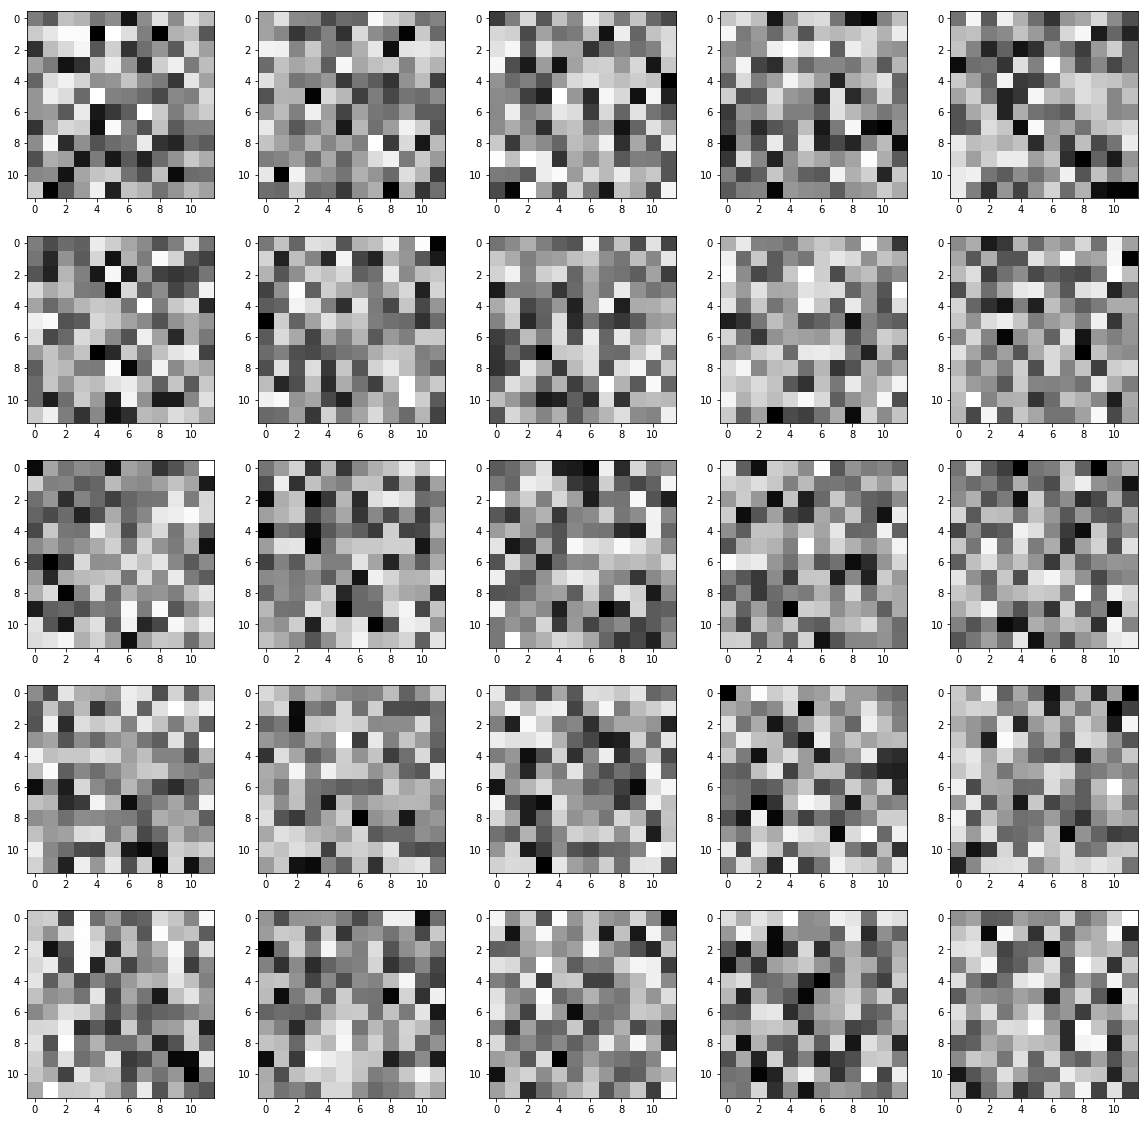

Do you want to visualize the top 12 patches: y
INFO:tensorflow:Restoring parameters from b'models/variables\\variables'
(10000, 9, 9, 5)
(0, 0, 0, 0)
(5451, 0, 0, 1)
(5451, 0, 0, 3)
(5451, 0, 0, 4)
(5451, 0, 1, 0)
(5451, 0, 1, 2)
(5451, 0, 1, 3)
(5451, 0, 1, 4)
(5451, 0, 2, 0)
(5451, 0, 2, 2)
(5451, 0, 2, 3)
(5451, 0, 3, 0)


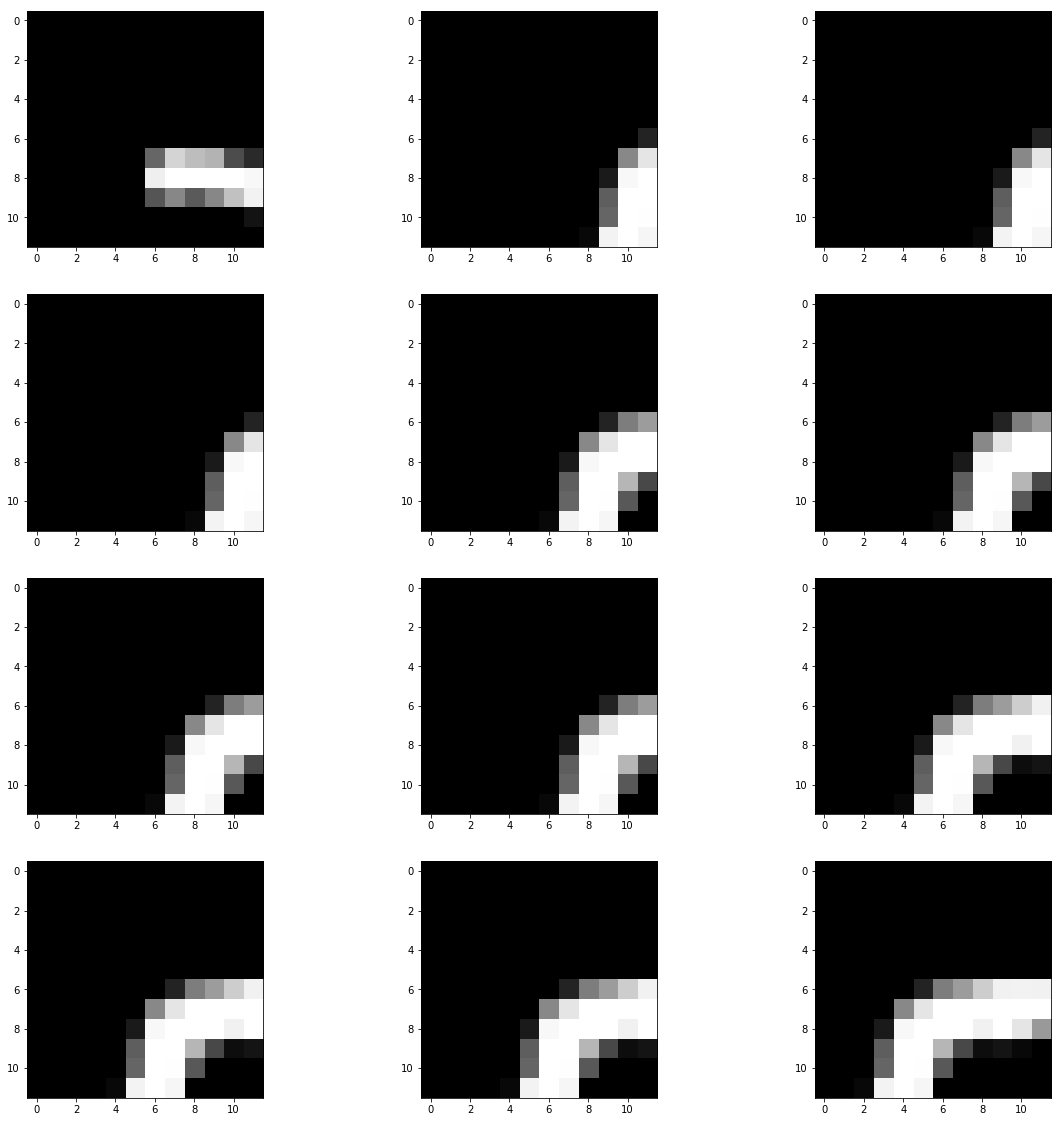

In [9]:
main()